### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tokenization
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize

# stopword removal
import nltk
import string
import re
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

# Vectorization/Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Neural Networks
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dropout, Input, Dense 
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.python.framework.random_seed import set_random_seed


datapath = 'data/'

2022-01-20 13:29:47.759109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 13:29:47.759133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load Data

In [2]:
data = pd.read_csv(datapath + 'disaster_train.csv', sep=',',)

### Tokenize data

we extract the text of the tweets as X vector and the transform them into a `tf-idf` (term-frequency times inverse document-frequency) matrix. 

__TODO__
- At a later stage add location and keyword data to the feature matrix
    - Problem: How do we addjust the weight of those, should they way as much as the occurence of one word or more?
    

In [3]:
# split feature vector and target vector
Y_train = data["target"].values 
X_train = data.values[:, 1:4]

# Get only column with tweet text
x_tweets = data['text']
x_tweets.head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [4]:
# Tweet tokenizer for making all alphabetical symbols lowercase, reducing length of words
# if they are e.g. 'goaaaal' and for removing account handles
tknzr = TweetTokenizer(preserve_case = False, strip_handles = True, reduce_len = True)
tweet_tokens = []
for sent in x_tweets:
    #print(tweet_tokenizer.tokenize(sent))
    tweet_tokens.append(tknzr.tokenize(sent))
print(tweet_tokens[:2])

[['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#earthquake', 'may', 'allah', 'forgive', 'us', 'all'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']]


In [5]:
# clean out stopwords, # signs, punctuation and numbers
clean_t2 = [[word if (word.startswith('#') == False) else re.sub(r'#', '', word) for word in tweet] for tweet in tweet_tokens]
clean_t3 = [[word for word in tweet if (word not in string.punctuation) and (word.isalpha() == True) and (word not in english_stopwords)] for tweet in clean_t2]
clean_t3[:2]

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']]

In [6]:
# Transform into correct input form for the Vectorizer
clean_t4 = [' '.join(tweet) for tweet in clean_t3]
x_tweets = np.array(clean_t4)
x_tweets[:2]

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada'], dtype='<U138')

In [7]:
# split train and test set
X_train, X_test, y_train, y_test = train_test_split(x_tweets, Y_train, test_size=0.15, random_state=42)

# create tf-idf vectorizer
tf_computer = TfidfVectorizer(use_idf=False, ngram_range=(1,1))

# tf_computer = TfidfVectorizer(use_idf=True, ngram_range=(1,3)) # Increasing n-gram range; IDF usage
# using IDF inclreases accuracy by a little bit

# vectorize train and test set
train_features = tf_computer.fit_transform(X_train)
test_features = tf_computer.transform(X_test)

print("vocabulary size:", len(tf_computer.vocabulary_))

vocabulary size: 12427


# First naive try

In [8]:
# select a linear model based on the assumption that specific words (linearly) imply a real disaster or not
# TODO: vary hpyerparameter alpha

clf = RidgeClassifier()
scores = cross_val_score(clf, train_features, y_train, cv=3, scoring="f1")
scores

array([0.7399651 , 0.73634204, 0.73012188])

In [9]:
clf.fit(train_features, y_train)
y_train_pred = clf.predict(train_features)
y_test_pred = clf.predict(test_features)


print('Train F1 score:', np.round(f1_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(f1_score(y_test, y_test_pred), 3))

Train F1 score: 0.927
Test F1 score: 0.749


This looks very much like overfitting

# Second (a bit less) naive try
Lets try a neural network.

### Create early stopping mechanism for NN

In [10]:
from keras.callbacks import EarlyStopping

# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 3, #number of epochs with no improvement
                   verbose=1)

np.random.seed(123)
set_random_seed(2)

In [11]:
# change to dense format to get the correct input for the keras model
train_features_den = train_features.todense()
test_features_den = test_features.todense()
feature_vector_length = train_features_den.shape[1]

# one-hot-encoding of labels
n_classes = len(set(y_train))
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

In [12]:
# keras does not provide f1 as a metric during training, so we need to calculate it by hand using precision and recall
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

2022-01-20 13:30:01.041427: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 13:30:01.041475: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 13:30:01.041513: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (siprius): /proc/driver/nvidia/version does not exist
2022-01-20 13:30:01.041987: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
from keras.models import Sequential

# create model layers
model = Sequential() 
model.add(Dense(input_dim = feature_vector_length, units=200 , activation='relu')) 
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax')) #output layer

# configure the model and start training
model.compile(loss='binary_crossentropy', #loss metric
    optimizer='adam',  #optimizer
    metrics=['accuracy', precision, recall]) #displayed metric


history = model.fit(train_features_den, y_train_cat, batch_size=100, epochs=10, verbose=2, validation_split=0.2, callbacks=[es])

Epoch 1/10
52/52 - 2s - loss: 0.6246 - accuracy: 0.6468 - precision: 0.6711 - recall: 0.6711 - val_loss: 0.5095 - val_accuracy: 0.7792 - val_precision: 0.7792 - val_recall: 0.7792 - 2s/epoch - 37ms/step
Epoch 2/10
52/52 - 1s - loss: 0.3219 - accuracy: 0.8804 - precision: 0.8804 - recall: 0.8804 - val_loss: 0.5201 - val_accuracy: 0.7869 - val_precision: 0.7869 - val_recall: 0.7869 - 1s/epoch - 25ms/step
Epoch 3/10
52/52 - 1s - loss: 0.1520 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9440 - val_loss: 0.6075 - val_accuracy: 0.7699 - val_precision: 0.7699 - val_recall: 0.7699 - 1s/epoch - 22ms/step
Epoch 4/10
52/52 - 1s - loss: 0.0941 - accuracy: 0.9681 - precision: 0.9681 - recall: 0.9681 - val_loss: 0.6916 - val_accuracy: 0.7660 - val_precision: 0.7660 - val_recall: 0.7660 - 1s/epoch - 23ms/step
Epoch 00004: early stopping


In [17]:
history_pd = pd.DataFrame(history.history)
history_pd['f1'] = 2/(1/history_pd['precision'] + 1/history_pd['recall'])
history_pd['val_f1'] = 2/(1/history_pd['val_precision'] + 1/history_pd['val_recall'])
history_pd

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,f1,val_f1
0,0.624583,0.646832,0.671148,0.671148,0.509464,0.779151,0.779151,0.779151,0.671148,0.779151
1,0.321932,0.880410,0.880410,0.880410,0.520080,0.786873,0.786873,0.786873,0.880410,0.786873
2,0.151989,0.943972,0.943972,0.943972,0.607520,0.769884,0.769884,0.769884,0.943972,0.769884
3,0.094060,0.968122,0.968122,0.968122,0.691635,0.766023,0.766023,0.766023,0.968122,0.766023


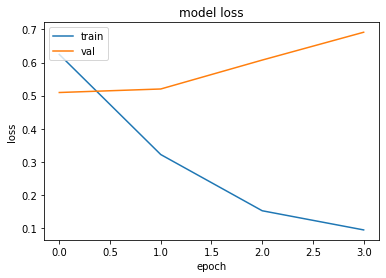

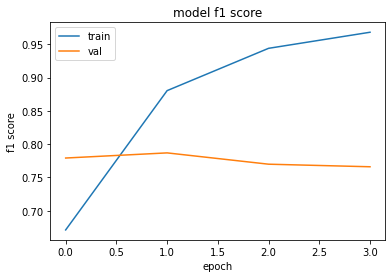

In [18]:
plt.plot(history_pd['loss'])
plt.plot(history_pd['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history_pd['f1'])
plt.plot(history_pd['val_f1'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.ylim(0.8, 1)
plt.show()


In [20]:
y_proba = model.predict(train_features_den)
y_train_pred = y_proba.argmax(axis=-1)

y_proba = model.predict(test_features.todense())
y_test_pred = y_proba.argmax(axis=-1)

print('Train F1 score:', np.round(f1_score(y_train, y_train_pred), 3))
print('Test F1 score:', np.round(f1_score(y_test, y_test_pred), 3))
print('\nTrain accuracy score:', np.round(accuracy_score(y_train, y_train_pred), 3))
print('Test accuray score:', np.round(accuracy_score(y_test, y_test_pred), 3))

Train F1 score: 0.929
Test F1 score: 0.71

Train accuracy score: 0.939
Test accuray score: 0.753


### Model Variation

In the following section we will try out different architectures for our model. To do so we will vary the activation function and the depth of the model.

In [21]:
#  the function can be used in a loop to define several models

def MLP_definer(n_layers, n_features, n_classes, activation_f):
    
    model = Sequential()
    model.add(Dense(input_dim = n_features, units=500, activation=activation_f))
    for i in range(1, n_layers):
        model.add(Dense(units=500-10*i^2, activation=activation_f))
        
    model.add(Dense(units=n_classes, activation='softmax'))
    return model

In [22]:
out = {}
for fun in ('relu', 'sigmoid'):
    print(f'\n ## Activation function {fun} ############################################################################')
    for i in range(2,5):    
        model = MLP_definer(i, n_features=feature_vector_length, n_classes=n_classes, activation_f=fun)
        model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', precision, recall] #displayed metric
        )
        history = model.fit(train_features_den, y_train_cat, batch_size=100, epochs=20, verbose=0, validation_split=0.2, callbacks=[es])
        out[i] = [history.history['accuracy'][-1],  history.history['val_accuracy'][-1]]
        print(f'Number of layers: {i} \nTrain Acc: {history.history["accuracy"][-1]} \nTest Acc:  {history.history["val_accuracy"][-1]}\n')


 ## Activation function relu ############################################################################
Epoch 00004: early stopping
Number of layers: 2 
Train Acc: 0.9741112589836121 
Test Acc:  0.7722007632255554

Epoch 00004: early stopping
Number of layers: 3 
Train Acc: 0.9770092964172363 
Test Acc:  0.7783783674240112

Epoch 00004: early stopping
Number of layers: 4 
Train Acc: 0.9781684875488281 
Test Acc:  0.7760617733001709


 ## Activation function sigmoid ############################################################################
Epoch 00008: early stopping
Number of layers: 2 
Train Acc: 0.9462905526161194 
Test Acc:  0.7760617733001709

Epoch 00009: early stopping
Number of layers: 3 
Train Acc: 0.9518933296203613 
Test Acc:  0.7814671993255615

Epoch 00009: early stopping
Number of layers: 4 
Train Acc: 0.5608578324317932 
Test Acc:  0.5652509927749634



### An SVM approach

In [23]:
#train the svc
svc_grid_params = {
    'C': (0.1, 1., 10),
    'kernel': ('rbf', 'linear'),
}

svc_clf = SVC(random_state= 123)
svc_v1 = GridSearchCV(svc_clf, svc_grid_params, n_jobs= -1, cv = 5)
svc_v1.fit(train_features, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=123), n_jobs=-1,
             param_grid={'C': (0.1, 1.0, 10), 'kernel': ('rbf', 'linear')})

In [24]:
svc_v1.best_params_

{'C': 1.0, 'kernel': 'linear'}

In [25]:
# check out accuracy
y_train_pred = svc_v1.predict(train_features)
y_test_pred = svc_v1.predict(test_features)
print(f"SVC.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tTest:{f1_score(y_test, y_test_pred,average = 'macro'):.4f}")

SVC.	Train:0.9066	Test:0.7783


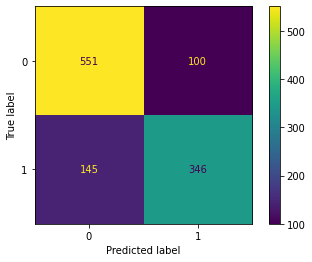

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#y_test_pred = svc_v1.predict(test_features)
cm = confusion_matrix(y_test, y_test_pred, labels=svc_v1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_v1.classes_)
disp.plot()
plt.show()